In [1]:
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A

import albumentations.pytorch

import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import GPUtil
from GPUtil import showUtilization as gpu_usage

import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from jupyterthemes import jtplot
import warnings

#import functools

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

In [3]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    

# Load data

In [4]:
cell_df = pd.read_csv('./sartorius-cell-instance-segmentation/train.csv')
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
23958,559904fcd4a2,325764 2 326464 8 327166 12 327868 15 328570 1...,704,520,cort,11h59m00s,2020-11-03,cort[debris]_D9-1_Vessel-384_Ph_3,0 days 11:59:00
49011,a96cf05207fc,33754 5 34458 7 35162 8 35865 9 36569 9 37273 ...,704,520,astro,09h00m00s,2020-09-12,astros[cereb]_F12-1_Vessel-361_Ph_4,0 days 09:00:00
37811,856cbd30d034,66381 2 67085 4 67788 7 68492 9 69195 11 69899...,704,520,cort,19h30m00s,2020-11-04,cort[6-OHDA]_G2-1_Vessel-377_Ph_3,0 days 19:30:00
23084,517648559341,238447 8 239147 18 239848 28 240552 29 241256 ...,704,520,shsy5y,11h30m00s,2019-06-14,shsy5y[diff]_D4-1_Vessel-714_Ph_1,0 days 11:30:00


In [5]:
TRAIN_DIR = Path('./sartorius-cell-instance-segmentation/train/')
TEST_DIR = Path('./sartorius-cell-instance-segmentation/test/')

In [6]:
train_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))

In [7]:
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


# Visualize the data

Create functions to make a mask based on annotations given in train.csv file

In [8]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [9]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width,3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height,width, 1))
    mask = mask.clip(0,1)
    return mask

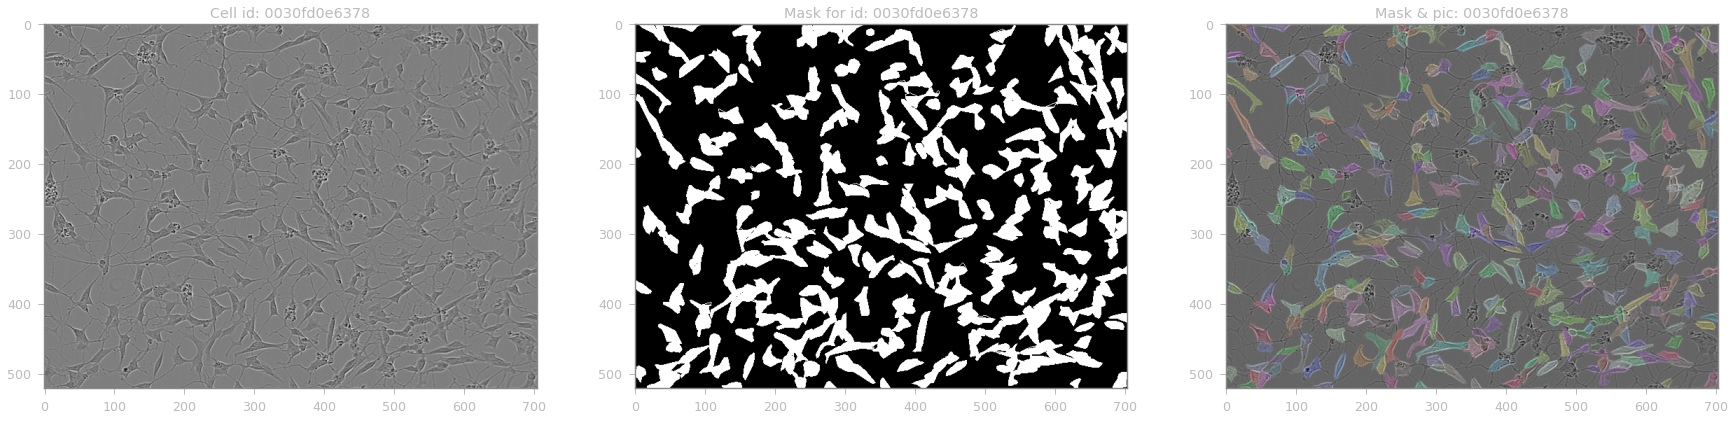

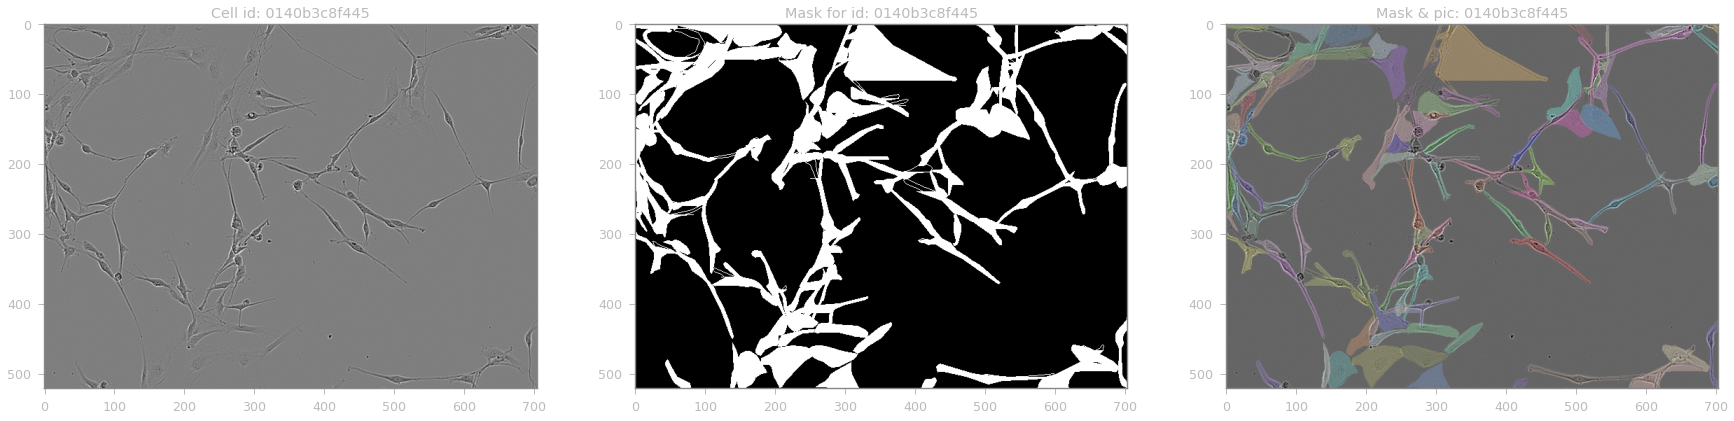

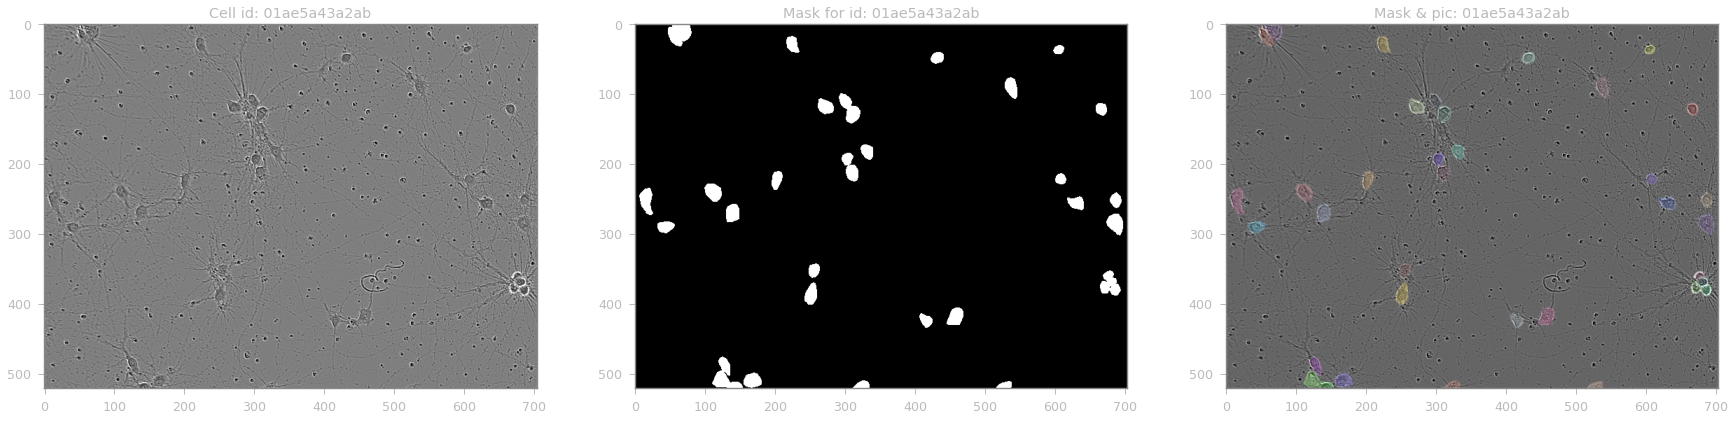

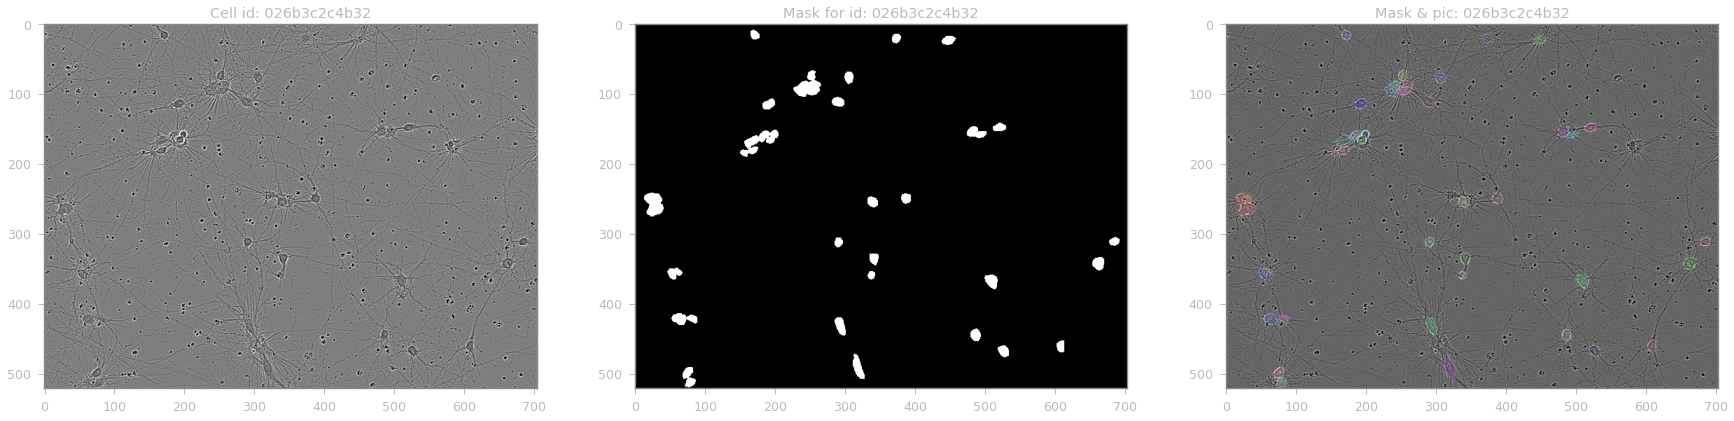

In [10]:
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    #label = (train_files[rand_idx]).name[:-4]
    label = (train_files[i]).stem#name[:-4]
    sample_im_df = cell_df[cell_df['id'] == label]
    sample_rles = sample_im_df['annotation'].values
    sample_masks1 = build_mask(sample_rles,input_shape=(520,704), colors=False)
    sample_masks2 = build_mask(sample_rles,input_shape=(520,704), colors=True)
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label))
    ax2.set_title('Mask for id: ' + str(label))
    ax3.set_title('Mask & pic: ' + str(label))
    plt.show();

# DataSets

In [11]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame, train:bool, transform=None):
        super().__init__()
        self.files = sorted(files)
        self.df = df
        self.gb = self.df.groupby('id')
        self.transform = transform      
        
        self.len_ = len(self.files)
    
    def __len__(self):
        return self.len_
    
    #@functools.lru_cache(12)
    def load_sample(self, file):
        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = np.expand_dims(img, axis=0)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self, index):
        
        # load image
        image, image_id = self.load_sample(self.files[index])
        annotation_df = self.gb.get_group(image_id)
        #annotation = self.gb.get_group(self.files[index].stem)
        #Create a mask
        annotations = annotation_df['annotation'].values
        mask = build_mask(annotations,input_shape=(520,704), colors=False)
        #mask = np.moveaxis(np.array(mask),2,0)
            
        if self.transform is not None:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            #mask = self.transform(image = mask)["image"]
        
        #image = np.expand_dims(image, axis=0)
        mask = np.moveaxis(np.array(mask),2,0)
        return image,mask

## Split train-val set

In [14]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.1)

In [15]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 545

Number of pictures in val set: 61


In [16]:
# split pandas dataframe with annotations for train df and val df
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 545

Number of picture's id in val set 61


In [24]:
def get_augmentation(pic_size,train:bool):
    if train == False:
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
#                                                     A.Normalize(
#                                                         mean=[0.485, 0.456, 0.406],
#                                                         std=[0.229, 0.224, 0.225]),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
#             A.OneOf([
#                 A.HorizontalFlip(p=0.5),
#                 A.RandomRotate90(p=0.5),
#                 A.VerticalFlip(p=0.5)], p=0.5),
#             A.OneOf([
#                 A.GaussNoise(),], p=1),
#             A.OneOf([
#                 A.MotionBlur(p=0.2),
#                 A.MedianBlur(blur_limit=3, p=0.1),
#                 A.Blur(blur_limit=3, p=0.1),], p=0.8),
#             A.ShiftScaleRotate(
#                 shift_limit=0.0625, 
#                 scale_limit=0.2, 
#                 rotate_limit=15, p=1),
#             A.OneOf([
#                 A.OpticalDistortion(p=0.5),
#                 A.GridDistortion(p=0.1),], p=0.5),
#             A.OneOf([
#                 A.CLAHE(clip_limit=2),
#                 A.RandomBrightnessContrast(),], p=0.5),
#             A.HueSaturationValue(p=0.3),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train

## Data Loaders

In [53]:
BATCH_SIZE = 8

In [54]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,train=True,
                             transform=get_augmentation(224, train=True)
                            )

In [55]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=4,) # pc -8 lap =4

In [56]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,
                           train=False,
                          transform=get_augmentation(224, train=False))

In [57]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=4) # pc -8 lap =4

In [58]:
batch = next(iter(train_loader))
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
del batch

image shape: torch.Size([8, 3, 224, 224]),
mask shape:torch.Size([8, 1, 224, 224]),
batch len: 2


# Unet-baseline

In [59]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [60]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [61]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
#         # input CxHxW
#         diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
#         diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        
#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [62]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [63]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [65]:
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
#     print(f"Initial GPU Usage at fit_epoch")
#     gpu_usage()
    
    for imgs, masks in pbar:
        optimizer.zero_grad()
        imgs=imgs.to(device).float()
        masks = masks.to(device).float()
        # forward
        
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]
        
        loss.backward()
#         print(f"In loop before del")
#         gpu_usage()
        del imgs, masks
#         print(f"Afteer deletion in loop")
#         gpu_usage()
        torch.cuda.empty_cache()
        
    running_loss /= len(train_loader.sampler)
    print('Train_loss: %f' % running_loss)
    torch.cuda.empty_cache()
    #print(f"Afteer deletion")
    #gpu_usage()
    return running_loss

In [66]:
from IPython.display import clear_output

In [38]:
def eval_loop(model, criterion, val_loader, device=device):
    running_loss=0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(val_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            imgs = imgs.to(device).float()
            masks = masks.to(device).float()
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            
            y_hat = (out > 0.5).float()
            y_hat = y_hat.view(-1).detach().cpu().numpy()
            labels = masks.view(-1).detach().cpu().numpy()
            accuracy.append(accuracy_score(labels, y_hat))
            f1_scores.append(f1_score(labels, y_hat))
            
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(val_loader.sampler)
    print('Val_loss: %f' % running_loss)
    del imgs, masks, y_hat, labels
    torch.cuda.empty_cache()
    
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}

In [39]:
def visualize_train(model,val_loader, device=device):
    model.eval()
    X_val, Y_val = next(iter(val_loader))
    Y_hat = model(X_val.to(device))
    Y_hat = Y_hat.detach().cpu().numpy()
    
    clear_output(wait=True)
    for k in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),)
        ax1.imshow(np.rollaxis(X_val[k].numpy(), 0, 3),cmap='gray')
        #ax2.imshow(((Y_hat[k, 0] * 255)).astype('uint8'), cmap='gray')
        ax2.imshow(((Y_hat[k, 0] * 255)), cmap='gray')
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax1.set_title('Real')
        ax2.set_title('Output')
    #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()
    del X_val, Y_hat

In [40]:
def train(model,optimizer,criterion,
          train_loader,val_loader,
          device=device,epochs=5,
          valid_loss_min=np.inf,vis=True):
    writer = SummaryWriter(comment=f'BS_{train_loader.batch_size}_Epchs_{epochs}')
    history = []
    
    
    for epoch in range(epochs):
        train_loss = train_loop(model,optimizer,criterion,train_loader,device=device)
        # evaluate on validation set
        metrics = eval_loop(model,criterion,val_loader,device=device)
        history.append((train_loss,metrics["loss"],metrics["accuracy"]))
        
        if vis:
            visualize_train(model,val_loader,device=device)
        
        # show progress
        print_string = f'Epoch: {epoch+1} '
        print_string+= f'TrainLoss from train func: {train_loss:.5f} '
        print_string+= f'ValidLoss from train func: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)
    
    return history

In [76]:
model = UNet(3,1)
model = model.to(device)

In [77]:
from Losses import ComboLoss, dice_metric
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})

In [69]:
# from https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [78]:
max_epochs = 5
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [79]:
history = train(model,optim,CRITERION,train_loader,val_loader,epochs=max_epochs, vis=False)

Iterating over train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:16<00:00,  1.11s/it]


Train_loss: 4.513419


Iterating over evaluation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.23it/s]


Val_loss: 4.466487
Epoch: 1 TrainLoss from train func: 4.51342 ValidLoss from train func: 4.46649 ACC: 0.72619 F1: 0.194


Iterating over train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:15<00:00,  1.10s/it]


Train_loss: 4.513419


Iterating over evaluation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


Val_loss: 4.482943
Epoch: 2 TrainLoss from train func: 4.51342 ValidLoss from train func: 4.48294 ACC: 0.72186 F1: 0.194


Iterating over train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:15<00:00,  1.10s/it]


Train_loss: 4.513419


Iterating over evaluation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


Val_loss: 4.482955
Epoch: 3 TrainLoss from train func: 4.51342 ValidLoss from train func: 4.48296 ACC: 0.72186 F1: 0.194


Iterating over train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:16<00:00,  1.10s/it]


Train_loss: 4.513419


Iterating over evaluation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.23it/s]


Val_loss: 4.482955
Epoch: 4 TrainLoss from train func: 4.51342 ValidLoss from train func: 4.48296 ACC: 0.72186 F1: 0.194


Iterating over train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:16<00:00,  1.10s/it]


Train_loss: 4.513419


Iterating over evaluation data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]

Val_loss: 4.482955
Epoch: 5 TrainLoss from train func: 4.51342 ValidLoss from train func: 4.48296 ACC: 0.72186 F1: 0.194


In [74]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, val_acc = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    #ax2.plot(acc, label="train_accuracy")
    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

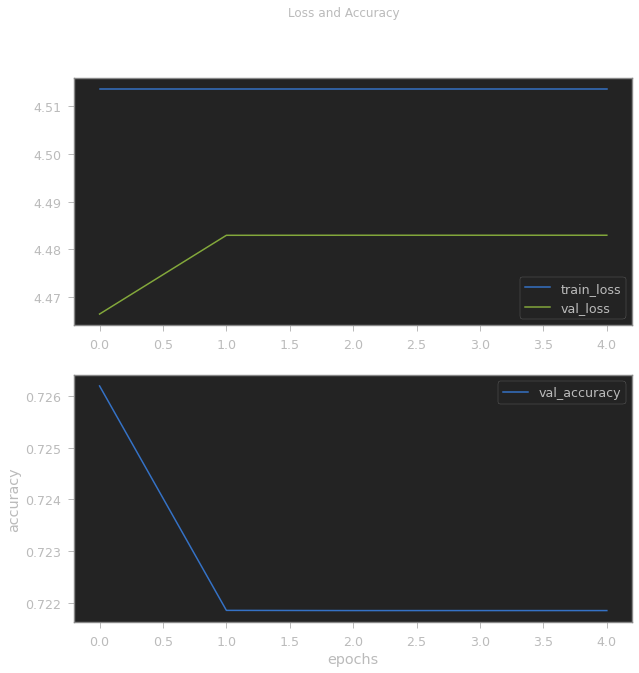

In [80]:
plot_loss_acc(history)